In [18]:
from autograd import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0


In [19]:
def make_pupil(radius,npix=128,rtot=20*units.m,offset=0.):
    x = np.linspace(-npix/2.,npix/2.,npix)-offset
    x = x*rtot/npix
    xx, yy = np.meshgrid(x,x)
    
    rr = np.sqrt(xx**2 + yy**2)
    mask = rr > radius
    pupil = np.ones_like(rr)
    pupil[mask] = 0
    return pupil.value

In [20]:
pupil = make_pupil(3*units.m)

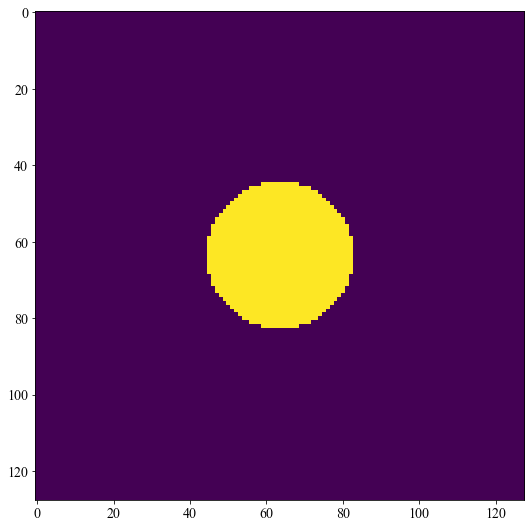

In [21]:
plt.imshow(pupil)

In [5]:
# =========================================================================
# =========================================================================

def mas2rad(x):
    ''' Convenient little function to convert milliarcsec to radians '''
    return x*np.pi/(180*3600*1000)

# =========================================================================
# =========================================================================

def rad2mas(x):
    ''' Convenient little function to convert radians to milliarcseconds '''
    return x/np.pi*(180*3600*1000)


In [22]:
fftshift = np.fft.fftshift
fft = np.fft.fft2

def propagate(pupil):
    scale = pupil
    return fftshift(fft(fftshift(pupil)))

In [23]:
psf = propagate(pupil)

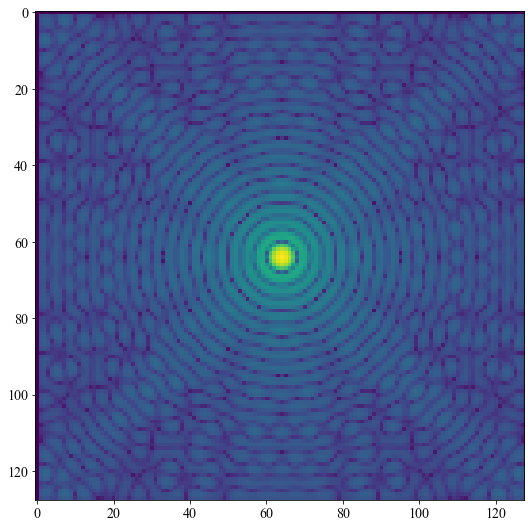

In [24]:
plt.imshow(np.abs(psf)**0.25)
# plt.xlim(500,524)
# plt.ylim(500,524)

In [25]:
uv = fftshift(fft((np.abs(psf)**2)))

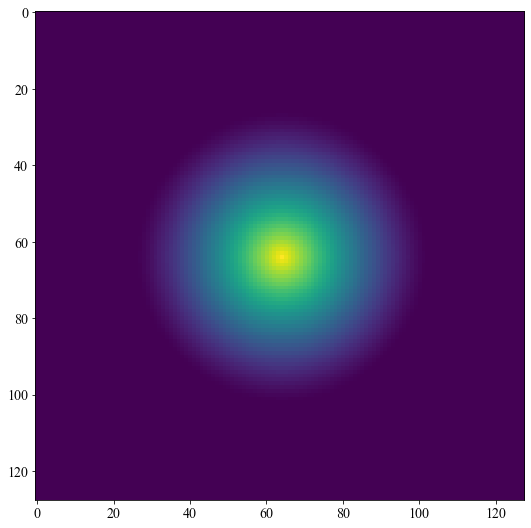

In [26]:
plt.imshow(np.abs(uv))

In [27]:
from autograd import grad, elementwise_grad, jacobian

In [28]:
def get_psf(screen):
    return propagate(pupil*np.exp(1.j*screen))
    
def get_uv(psf):
    return fftshift(fft(fftshift(np.abs(psf)**2)))

def get_phases(screen):
    return np.angle(get_uv(get_psf(screen)))

In [13]:
from scipy.signal import correlate2d, convolve2d

In [14]:
support = convolve2d(pupil,pupil,mode='same')>0

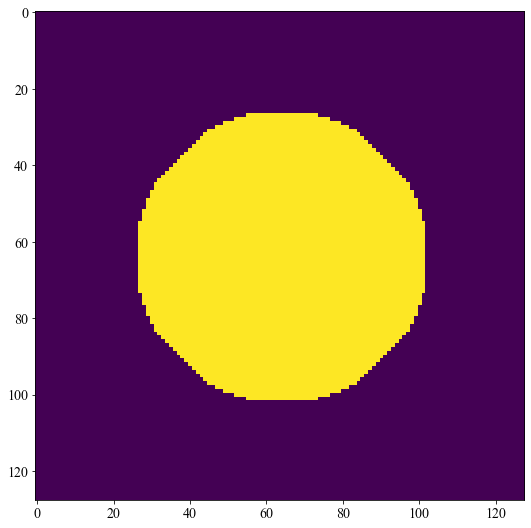

In [15]:
plt.imshow(support)

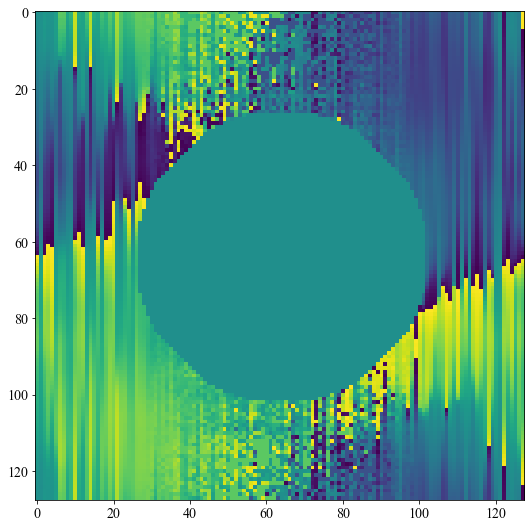

In [16]:
plt.imshow(get_phases(np.zeros_like(pupil)))

In [17]:
def scalar(screen):
    return np.sum(get_phases(screen))
onegrad = grad(scalar)
thisgrad = onegrad(np.zeros_like(pupil))
print(thisgrad)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/Users/benjaminpope/opt/anaconda3/envs/jax/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:129: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.angle,  lambda ans, x   : lambda g: match_complex(x, g * anp.conj(x * 1j) / anp.abs(x)**2))


In [20]:
phasegrad = jacobian(get_phases)

In [ ]:
plt.imshow((get_phases(pupil)))


In [ ]:
plt.imshow(np.abs(get_uv(psf))**0.2)

In [ ]:
%%time 
thisgrad = phasegrad(np.zeros_like(pupil))

In [ ]:
get_phases(np.zeros_like(pupil))

In [ ]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 32


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
        ax[i,1+j].imshow(thisgrad[indices,indices,:,:],cmap=phasemap)
        ax[i,1+j].set_xlim(32,128-32)
        ax[i,1+j].set_ylim(128-32,32)
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('u,v')

        ax[i,j].imshow(support)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        indices += 4

plt.savefig('jacobian.png',bbox_inches='tight')
# plt.savefig('../paper/jacobian.pdf',bbox_inches='tight')

In [ ]:
transfer_martinache = thisgrad[support>0,:,:][:,pupil>0]

In [ ]:
%%time
u1, s1, v1 = np.linalg.svd(transfer_martinache,full_matrices=False)

In [ ]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s1)
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
plt.title('Full Pupil',y=1.01,fontsize=20)
plt.savefig('kerphi_singular.png',bbox_inches='tight')
plt.savefig('../paper/kerphi_singular.pdf',bbox_inches='tight')

### Now let's try a coronagraph!

In [ ]:
x = np.linspace(-psf.shape[0]/2.,psf.shape[0]/2.,psf.shape[0])


In [ ]:
x.min(),x.max()

In [ ]:
xx, yy = np.meshgrid(x,x)
xx.min(),xx.max()

In [ ]:
def make_stop(psf):
    x = np.linspace(-psf.shape[0]/2.,psf.shape[0]/2.,psf.shape[0])-0.5
    xx, yy = np.meshgrid(x,x)
    
    rr = np.sqrt(xx**2 + yy**2)
    mask = rr < 8.
    stop = np.ones_like(rr)
    stop[mask] = 0
    return stop



In [ ]:
stop = make_stop(psf)
stopped = stop*psf
plt.imshow(np.abs(stopped))

In [ ]:
lyot = make_pupil(3*units.m*0.85,npix=128,rtot=20*units.m,offset=1)

In [ ]:
lyot_plane = propagate(stopped)

In [ ]:
test = (propagate(psf))
plt.imshow(np.abs(test)**0.25)

In [ ]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(lyot_plane)**0.2)
ax2.imshow(np.abs(lyot_plane*lyot)**0.2)

In [ ]:
final = propagate(lyot_plane*lyot)

In [ ]:
plt.imshow(np.abs(final))

In [ ]:
def get_speckles(screen):
    return np.abs(propagate(lyot*propagate(stop*get_psf(screen))))

In [ ]:
speckles = get_speckles(np.zeros_like(pupil))
plt.imshow(np.abs(speckles))

In [ ]:
speckle_grad = jacobian(get_speckles)

In [ ]:
%%time 
new_grad = speckle_grad(np.zeros_like(pupil))

In [ ]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 32


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
        phases = new_grad[indices,indices,:,:]
        phases[pupil==0] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)
        ax[i,1+j].set_xlim(32,128-32)
        ax[i,1+j].set_ylim(128-32,32)
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('PSF')

        ax[i,j].imshow(speckles)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        indices += 4

plt.savefig('speckle_jacobian.png',bbox_inches='tight')
plt.savefig('../paper/speckle_jacobian.pdf',bbox_inches='tight')

### Let's make this into a phase transfer matrix

In [ ]:
new_grad.shape

In [ ]:
test = np.reshape(new_grad,(128**2,128**2))

In [ ]:
test.shape

In [ ]:
plt.imshow(np.reshape(test,(128,128,128,128))[55,55,:,:])

In [ ]:
transfer = new_grad[:,:,pupil>0].reshape(128**2,np.sum(pupil>0))

In [ ]:
transfer.shape

In [ ]:
%%time
u, s, v = np.linalg.svd(transfer,full_matrices=False)

In [ ]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s)
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Singular Value Spectrum of a Lyot Coronagraph',fontsize=24,y=1.01)
plt.title('Lyot', y=1.01,fontsize=20)
# plt.savefig('coronagraph_singular.png',bbox_inches='tight')
# plt.savefig('../paper/coronagraph_singular.pdf',bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(9.0,6.0))
plt.plot(s1/s1[0],label='Full Pupil')
plt.plot(s/s[0],label='Lyot')
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')

# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
# plt.title('Full Pupil',y=1.01,fontsize=20)
plt.legend(fontsize=20,frameon=False)
plt.savefig('all_singular.png',bbox_inches='tight')
plt.savefig('../paper/all_singular.pdf',bbox_inches='tight')

In [ ]:
s[1000]/s[0]

In [ ]:
plt.imshow(u[:,0].reshape(128,128))

In [ ]:
mask = pupil>0
wavefront = np.ones_like(pupil)
wavefront[mask] *= v[1100,:]
wavefront[~mask] = np.nan

plt.imshow(wavefront)

plt.xlim(32,128-32)
plt.ylim(32,128-32)

In [ ]:
plt.imshow(u[:,1136].reshape(128,128))

In [ ]:
nsets = 3

fig, axes = plt.subplots(nsets,3,figsize=(12.0,12/3.*nsets),sharex=True, sharey=True)

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_title('Nonsingular',fontsize=18,y=1.05)
axes[0,1].set_title('Small',fontsize=18,y=1.05)
axes[0,2].set_title('Singular',fontsize=18,y=1.05)

for j in range(nsets):
    axes[j,0].imshow(u[:,j*10].reshape(128,128))
    
for j in range(nsets):
    axes[j,1].imshow(u[:,600+j*10].reshape(128,128))
    
for j in range(nsets):
    axes[j,2].imshow(u[:,1000+j*10].reshape(128,128))
    
plt.savefig('../paper/coronagraph_kernel.pdf',bbox_inches='tight')

In [ ]:
nsets = 2

fig, axes = plt.subplots(nsets*2,3,figsize=(12.0,12/3.*(nsets*2)))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_title('Nonsingular',fontsize=18,y=1.05)
axes[0,1].set_title('Small',fontsize=18,y=1.05)
axes[0,2].set_title('Singular',fontsize=18,y=1.05)


for j in range(nsets):
    axes[j*2+1,0].imshow(u[:,j*10].reshape(128,128))
    wavefront = np.ones_like(pupil)
    wavefront[mask] *= v[j*10,:]
    wavefront[~mask] = np.nan
    axes[j*2,0].imshow(wavefront,cmap=phasemap)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

    axes[j*2,0].set_xlim(32,128-32)
    axes[j*2,0].set_ylim(128-32,32)

    
for j in range(nsets):
    axes[j*2+1,1].imshow(u[:,600+j*10].reshape(128,128))
    wavefront = np.ones_like(pupil)
    wavefront[mask] *= v[600+j*10,:]
    wavefront[~mask] = np.nan
    axes[j*2,1].imshow(wavefront,cmap=phasemap)
    axes[j*2,1].set_xlim(32,128-32)
    axes[j*2,1].set_ylim(128-32,32)

for j in range(nsets):
    axes[j*2+1,2].imshow(u[:,1000+j*10].reshape(128,128))
    wavefront = np.ones_like(pupil)
    wavefront[mask] *= v[1000+j*10,:]
    wavefront[~mask] = np.nan
    axes[j*2,2].imshow(wavefront,cmap=phasemap)
    axes[j*2,2].set_xlim(32,128-32)
    axes[j*2,2].set_ylim(128-32,32)

plt.savefig('../paper/coronagraph_kernel.pdf',bbox_inches='tight')

In [ ]:
wavefront = np.ones_like(pupil)
wavefront[mask] *= v[600,:]
wavefront[~mask] = 0
wavefront = 0.001*wavefront/wavefront.max()

In [ ]:
test = get_speckles(wavefront)
ref = get_speckles(np.zeros_like(pupil))

In [ ]:
fig, axes = plt.subplots(1,3,figsize=[12.0,4.0])
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')
black = np.ones_like(wavefront)
black[~mask] = np.nan
axes[0].imshow(wavefront*black,cmap=phasemap)
axes[0].set_xlim(32,128-32)
axes[0].set_ylim(128-32,32)
axes[1].imshow(np.abs(test))
axes[2].imshow((np.abs(test)-np.abs(ref))/np.median(np.abs(ref)))
# plt.colorbar()

In [ ]:
wavefront = np.ones_like(pupil)
wavefront[mask] *= v[0,:]
wavefront[~mask] = 0
wavefront = 0.001*wavefront/wavefront.max()

In [ ]:
test = get_speckles(wavefront)
ref = get_speckles(np.zeros_like(pupil))

In [ ]:
plt.imshow(np.abs(test)-np.abs(ref))
plt.colorbar()

In [ ]:
fig, axes = plt.subplots(1,3,figsize=[12.0,4.0])
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')
black = np.ones_like(wavefront)
black[~mask] = np.nan
axes[0].imshow(wavefront*black,cmap=phasemap)
axes[0].set_xlim(32,128-32)
axes[0].set_ylim(128-32,32)
axes[1].imshow(np.abs(test))
axes[2].imshow((np.abs(test)-np.abs(ref))/np.median(np.abs(ref)))
# plt.colorbar()

###  How singular are these vectors?

In [ ]:
def mad(a,b):
    return np.nanmedian(np.abs(a-b))

from tqdm import tqdm

In [ ]:
mads = []
mads2 = []
mads3 = []

ref = get_speckles(np.zeros_like(pupil))

for j in tqdm(range(s.shape[0])):
    wavefront = np.ones_like(pupil)
    wavefront[mask] *= v[j,:]
    wavefront[~mask] = 0
    wavefront = 0.001*wavefront/wavefront.max()
    mads.append(mad(np.abs(get_speckles(wavefront)),ref))
    mads2.append(mad(np.abs(get_speckles(wavefront*10)),ref))
    mads3.append(mad(np.abs(get_speckles(wavefront*100)),ref))

mads = np.array(mads)/np.max(ref)
mads2 = np.array(mads2)/np.max(ref)
mads3 = np.array(mads3)/np.max(ref)

In [ ]:
fig = plt.figure(figsize=(9.0,6.0))
plt.plot(mads,label=r'$10^{-3}$ rad')
plt.plot(mads2,label=r'$10^{-2}$ rad')
plt.plot(mads3,label=r'$10^{-1}$ rad')

plt.yscale('log')
plt.ylabel('MAD')
plt.xlabel('Index')
# plt.title('Singular Value Spectrum of a Lyot Coronagraph',fontsize=24,y=1.01)
# plt.title('Lyot', y=1.01,fontsize=20)
plt.axvline(405,linestyle='--',alpha=0.7)
plt.text(405-150,0.02e-4,'Rolloff',fontsize=16)
plt.axvline(441,linestyle='--',alpha=0.7)
plt.text(441+10,0.02e-4,'Kernel',fontsize=16)
plt.axvline(958,linestyle='--',alpha=0.7)
plt.text(958+10,0.02e-4,'Lyot Stop',fontsize=16)
plt.savefig('coronagraph_mad.png',bbox_inches='tight')
plt.legend(loc=3,frameon=False,fontsize=16)
plt.savefig('../paper/coronagraph_mad.pdf',bbox_inches='tight')

In [ ]:
np.min(np.where(s/s[0]<1e-4))

### Pretty singular! 

How many are under the Lyot stop?

In [ ]:
print('Minimum Lyot index:',np.min(np.where(s==s[1000])))
print('# Lyot:',s.shape[0]-np.min(np.where(s==s[1000])))
print('# Lyot pixels:',np.sum(mask)-np.sum(lyot>0))

How many approximately singular values are there?

In [ ]:
print('# "True" kernel:',np.min(np.where(s==s[1000]))-np.max(np.where(s/s[0] > 1e-4)))
print('# Rolloff:',np.max(np.where(s/s[0] > 1e-4))-np.max(np.where(s/s[0] > 0.5)))


In [ ]:
np.sum(mask)-np.sum(lyot>0)

In [ ]:
np.max(np.where(s/s[0] > 1e-4))

In [ ]:
plt.plot(s/s[0] > 0.5)

### What is the power spectrum of phase and amplitude variation like as a function of singular value index?

In [ ]:
support_lyot = convolve2d(lyot,lyot,mode='same')>0

In [ ]:
enclosed = []
for j in tqdm(range(s.shape[0])):

    thisuv = np.abs(get_uv(u[:,j].reshape((128,128))))**2.
    enclosed.append(thisuv[support].sum()/thisuv[~support].sum())
enclosed = np.array(enclosed)

In [ ]:
plt.imshow(thisuv)

In [ ]:
np.min(np.where(enclosed<1e6))

In [ ]:
plt.plot(enclosed)
# plt.yscale('log')

### Now let's simulate a planet!

In [ ]:
a, b = 1.0, 1.0
tilt = a*xx + b*yy
tilt /= tilt.max()
nld = 20

tilt *= (nld*2*np.pi)

In [ ]:
plt.imshow(tilt)
plt.colorbar()

In [ ]:
planet = get_speckles(tilt)

In [ ]:
plt.imshow(planet)

In [ ]:
planet /= planet.max()
planet *= 1.e-2

### Now let's get a projection operator down to the kernel space

In [ ]:
kernel = u[:,441:]
tangent = u[:,:441]

In [ ]:
obs = planet+ref/ref.max() 
component = np.dot(u[:,441:].T,obs.ravel())
# kernel_speckles = np.dot(kernel.T,component).reshape((128,128))

In [ ]:
component.shape

In [ ]:
plt.imshow(kernel)

In [ ]:
plt.imshow(planet+ref-bad)

In [ ]:
component = np.dot(u[:,:441].T,ref.ravel())
bad = np.dot(component,u[:,:441].T).reshape((128,128))

In [ ]:
plt.imshow(bad)

In [ ]:
holder_kernel = []
holder_tangent = []

for j in range(10):
    test = get_speckles(0.1*np.random.randn(*pupil.shape))
    obs = planet+test/test.max() 
    component = np.dot(kernel.T,obs.ravel())
    holder_kernel.append(component)
    ortho = np.dot(tangent.T,obs.ravel())
    holder_tangent.append(ortho)
holder_kernel = np.array(holder_kernel)
holder_tangent = np.array(holder_tangent)

In [ ]:
plt.errorbar(np.arange(holder_kernel.shape[1]),holder_kernel.mean(axis=0),yerr=holder_kernel.std(axis=0),linestyle='none')

In [ ]:
plt.errorbar(np.arange(holder_tangent.shape[1]),holder_tangent.mean(axis=0),yerr=holder_tangent.std(axis=0),linestyle='none')